# Segmentation

![](https://miro.medium.com/max/981/1*TPue9ee6I3iTNKz-clF4fA.png)

在影像分類 (Image classification) 任務中，我們會對輸入神經網路的影像進行分類

- Input: 影像 (bs, c$^*$, h, w) (c$^*$ = 3 if RGB else 1)
- Label: 類別 (bs, 1)

每一張影像都有一個對應的標籤標示這張影像屬於哪一個類別

不同於影像分類，影像分割是把每一個 pixel 點做分類 (背景、貓、狗、人等等)，影像分類與影像分割都是對影像分類，不過兩者有些許不同

- Image Classification: 對整張影像分類
- Image Segmentation: 對一張影像的每個 pixel 點分類

在影像分割的任務中，輸出與標籤的長寬都需要與原圖 (輸入) 相同

- Input: 影像 (bs, c$^*$, h, w) (c$^*$ = 3 if RGB else 1)
- Label: 影像 (bs, h, w)
- Output: 影像 (bs, c, h, w) (c 為分割類別數量)

其輸入與標籤如下圖

![](https://miro.medium.com/max/1332/1*tL8lb7J158bWbXEmLenGtw.png)

在這個例子中，影像對應的標籤大小為 (1, 6, 12, 18)，在第二個維度上表示的是屬於每一個類別的可能性，你可以想像成機率，我們通常會對這個維度做 log_softmax，在進行交叉墒的計算，舉例來說 (b, 1, i, j) 代表在批次中第 b 張圖的 i, j 位置屬於標籤一 (person) 的可能性有多大 

## 怎麼建立神經網路

大部分的神經網路分為兩個部分，第一個部分用來提取你網路的特徵，第二個部分用來完成你的任務

舉例來說，在影像分類任務中，我們的任務是知道影像屬於哪一個類別，為了讓模型知道怎麼去分辨一張影像，我們需要讓模型懂得去提取影像的特徵，例如模型看到手腳，就會知道這張影可能與人有關，在這個過程中，Convolution 用來提取影像特徵，Linear 用來判斷是不是人

整個流程可以簡化為:

特徵提取 (了解影像) $\to$ 分類任務 (做出判斷)，寫成神經網路的形式為

backbone (特稱提取) $\to$ classifier (分類任務)

那麼在影像分割中，我們怎麼讓模型做出判斷呢? 因為特徵圖一定程度上代表了影像的分割，所以一種最傳統的方法 FCN (Fully Convolution Network) 把特徵圖放大之後再通過幾個 Convolution 作為影像分割的任務

backbone (特稱提取) $\to$ FCNHead (放大計算)

### 怎麼衡量模型表現

影像分割中使用的指標是 mIoU (mean Intersection of Union) 和 Accuracy，mIoU 主要計算兩個集合的重疊度，分別為 Ground Truth (標籤) 和 Preditction (預測)

- TP$_k$: pixels 預測類別**為**真實的類別 ($k$)，且正確 (pixels 實際上為類別 $k$)
- TN$_k$: pixels 預測類別**非**真實的類別 ($k$)，且正確 (pixels 實際上非類別 $k$)
- FP$_k$: pixels 預測類別**為**真實的類別 ($k$)，且錯誤 (pixels 實際上非類別 $k$)
- FN$_k$: pixels 預測類別**非**真實的類別 ($k$)，且錯誤 (pixels 實際上為類別 
$k$)

#### Global Accuracy

Global Acc 計算的是 $\frac{1}{K+1}\sum_k$ (TP$_k$ + TN$_k$) / (TP$_k$ + FP$_k$ + FN$_k$ + TN$_k$)，注意到在該式子中，分子為預測正確的 pixels，分母為全部的 pixels

理想情況 Global Acc 應該接近於 1

#### mIoU

mIoU 計算的是 $\frac{1}{K+1}\sum_k$ TP$_k$ / (FN$_k$ + FP$_k$ + TP$_k$)，注意到在該式子中，分子為預測與真實的交集，分母為預測與真實的聯集

![](https://www.mathworks.com/help/vision/ref/jaccard.png)

理想情況 mIoU 應該接近於 1



In [ ]:
pip install prefetch_generator

  Preparing metadata (setup.py) ... - done
  Created wheel for prefetch_generator: filename=prefetch_generator-1.0.1-py3-none-any.whl size=3961 sha256=635339996923686eeb4784565075baf5b46983a92d2f5b73fd8a9b15c99f656e
  Stored in directory: /root/.cache/pip/wheels/b0/74/c0/b1e681a9b923c953cb89ef3e9bb21c32b3226b50a6911c7080
Successfully built prefetch_generator
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from torch.utils.data import DataLoader
from prefetch_generator import BackgroundGenerator

class DataLoaderX(DataLoader):

    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [ ]:
"""Data utility functions."""
import os

import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import matplotlib.cm as cm

import _pickle as pickle

def convert_color(color_code):
    code = color_code.replace("#", "")
    code_length = len(code)
    if code_length == 0 or code_length % 4:
        raise ValueError(f"Color code error. ({color_code})")
    pic_len = code_length // 4
    pics = [code[i:i + pic_len] for i in range(0, code_length, pic_len)]
    pics = [int(pic, base=16) for pic in pics]
    return pics

def label_img_to_rgb(label_img, cmap=cm.hot, void_color=None):
    label_img = np.squeeze(label_img)
    label_img_rgb = 255 * cmap(label_img)
    
    if isinstance(void_color, str):
        void_color = convert_color(void_color)
        mask = label_img == 0
        label_img_rgb[mask] = void_color

    return label_img_rgb.astype(np.uint8)


class SegmentationData(data.Dataset):

    def __init__(self, image_paths_file, center_crop=True):
        self.root_dir_name = os.path.dirname(image_paths_file)
        self.dataset_dir_name = os.path.join(self.root_dir_name, "images")
        self.target_dir_name = os.path.join(self.root_dir_name, "annotations_instance")
        self.img_transform = transforms.Compose([
            *([transforms.CenterCrop(240)] if center_crop else []),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )
        ])
        self.center_crop = center_crop
        self.cp = transforms.CenterCrop(240)
        with open(image_paths_file) as f:
            self.image_names = f.read().splitlines()

    def __getitem__(self, key):
        if isinstance(key, slice):
            # get the start, stop, and step from the slice
            return [self[ii] for ii in range(*key.indices(len(self)))]
        elif isinstance(key, list):
            # get the list of the images
            return [self[ii] for ii in key]
        else:
            # handle negative indices
            if key < 0:
                key += len(self)
            if key < 0 or key >= len(self):
                raise IndexError("The index (%d) is out of range." % key)
            # get the data from direct index
            return self.get_item_from_index(key)
        #else:
        #    raise TypeError(f"Invalid argument type. {key}: \"{type(key)}\"")

    def __len__(self):
        return len(self.image_names)

    def get_item_from_index(self, index):
        to_tensor = transforms.ToTensor()
        
        img_id = self.image_names[index].replace('.jpg', '')
        
        img_path = os.path.join(self.dataset_dir_name, img_id + ".jpg")
        img = Image.open(img_path).convert('RGB')
        
        img = self.img_transform(img)

        target_path = os.path.join(self.target_dir_name, img_id + ".png")
        target = Image.open(target_path)
        
        if self.center_crop: target = self.cp(target)
        target = np.array(target, dtype=np.int64)

        target_labels = target[:, :, 0]
        target_labels = torch.from_numpy(target_labels)

        return img, target_labels

In [ ]:
"""Utils for visualizations in notebooks"""
import matplotlib.pyplot as plt
import torch
from math import sqrt, ceil
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def visualizer(model, test_data=None, num_example_imgs=4, rand=False, **kwargs):
    indices = np.random.choice(len(test_data), num_example_imgs, replace=False) if rand else range(num_example_imgs)
    plt.figure(figsize=(15, 5 * num_example_imgs))
    for i, (img, target) in enumerate((test_data[i] for i in map(int, indices))):
        inputs = img.unsqueeze(0)
        inputs = inputs.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        pred = preds[0].data.cpu()

        img, target, pred = img.numpy(), target.numpy(), pred.numpy()

        # img
        plt.subplot(num_example_imgs, 3, i * 3 + 1)
        plt.axis('off')
        plt.imshow(img.transpose(1, 2, 0))
        if i == 0:
            plt.title("Input image")

        # target
        plt.subplot(num_example_imgs, 3, i * 3 + 2)
        plt.axis('off')
        plt.imshow(label_img_to_rgb(target, **kwargs))
        if i == 0:
            plt.title("Target image")

        # pred
        plt.subplot(num_example_imgs, 3, i * 3 + 3)
        plt.axis('off')
        plt.imshow(label_img_to_rgb(pred, **kwargs))
        if i == 0:
            plt.title("Prediction image")

    plt.show()

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                next_idx += 1
        x0 += W + padding
        x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

In [ ]:
def stack_data(data_list):
    return [torch.stack(data) for data in zip(*data_list)]

def predict_class(outputs):
    return torch.max(outputs, 1)[1]

def Mean_IoU(y_pred, y_true, class_labels=range(1, 101)):
    cumulative_IoU = torch.zeros(y_pred.shape[0]).to(device)
    class_count = torch.zeros(y_pred.shape[0], dtype=int).to(device)
    for c in class_labels:
        pred, truth = y_pred == c, y_true == c
        overlap, union = (pred & truth).sum(axis=(1, 2)), (pred | truth).sum(axis=(1, 2))
        IoU = overlap / union
        IoU[union == 0] = 0
        cumulative_IoU += IoU
        class_count += union != 0
    m_IoU = cumulative_IoU / class_count
    m_IoU[class_count == 0] = 1
    return m_IoU

In [ ]:
"""SegmentationNN"""
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
import torchvision.transforms as transforms

class SegmentationNN(pl.LightningModule):

    _default_hparams = {
        "batch_size": 256,
        "learning_rate": 0.001,
        "beta1": 0.9,
        "beta2": 0.999,
        "eps": 1e-8,
        "L2": 0,
    }

    def __init__(self, num_classes=100, train_set=None, val_set=None, hparams=None):
        super().__init__()
        self.hparams.update(SegmentationNN._default_hparams)
        self.hparams.update(hparams)
        self.data = { "train": train_set, "val": val_set }
        
        self.model = models.segmentation.fcn_resnet101(pretrained=False)
        #self.model.backbone.requires_grad_(False)

        self.model.classifier = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
        )

        self.loss = nn.CrossEntropyLoss(reduction='mean')

    def forward(self, x):
        """
        Forward pass of the convolutional neural network. Should not be called
        manually but by calling a model instance directly.

        Inputs:
        - x: PyTorch input Variable
        """
        x = self.model(x)["out"]
        return x

    @property
    def is_cuda(self):
        """
        Check if model parameters are allocated on the GPU.
        """
        return next(self.parameters()).is_cuda

    def save(self, path):
        """
        Save model with its parameters to the given path. Conventionally the
        path should end with "*.model".

        Inputs:
        - path: path string
        """
        print('Saving model... %s' % path)
        torch.save(self, path)

    def general_step(self, batch, batch_idx, mode):
        images, targets = batch

        # forward pass
        out = self.forward(images)

        # loss
        loss = self.loss(out, targets)
        
        # meanIoU
        out_classes = predict_class(out)
        m_IoU = Mean_IoU(out_classes, targets)

        return loss, m_IoU.mean()
    
    def training_step(self, batch, batch_idx):
        loss, m_IoU = self.general_step(batch, batch_idx, "train")
        self.log('loss', loss)
        self.log('mean_IoU', m_IoU)
        return {'loss': loss, 'mean_IoU': m_IoU}

    def validation_step(self, batch, batch_idx):
        loss, m_IoU = self.general_step(batch, batch_idx, "val")
        self.log('val_loss', loss)
        self.log('val_mean_IoU', m_IoU)
        return {'val_loss': loss, 'val_mean_IoU': m_IoU}

    def validation_step_end(self, output):
        return output

    def validation_epoch_end(self, outputs):
        steps = len(outputs)
        val_loss, m_IoU = 0, 0
        for output in outputs:
            val_loss += output['val_loss']
            m_IoU    += output['val_mean_IoU']
        val_loss, m_IoU = val_loss / steps, m_IoU / steps
        return {'val_loss': val_loss, 'val_mean_IoU': m_IoU}

    def train_dataloader(self):
        #return torch.utils.data.DataLoader(self.data['train'], shuffle=True, batch_size=self.hparams['batch_size'], num_workers=4)
        return DataLoaderX(self.data['train'], shuffle=True, batch_size=self.hparams['batch_size'], num_workers=2)

    def val_dataloader(self):
        #return torch.utils.data.DataLoader(self.data['val'], batch_size=self.hparams['batch_size'], num_workers=4)
        return DataLoaderX(self.data['val'], batch_size=self.hparams['batch_size'], num_workers=2)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
            lr=self.hparams['learning_rate'],
            betas=(self.hparams['beta1'], self.hparams['beta2']),
            eps=self.hparams['eps'],
            weight_decay=self.hparams['L2'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, patience=2)
        return  {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

In [ ]:
DATA_PATH = r"../input/ade20k/"

In [ ]:
train_data = SegmentationData(os.path.join(DATA_PATH, "training.txt"))
val_data   = SegmentationData(os.path.join(DATA_PATH, "validation.txt"))
train_size = int(len(train_data) * 0.90)
train_data, test_data = data.random_split(train_data, [train_size, len(train_data) - train_size])

train_inds = np.random.choice(len(train_data), 800, replace=True)
test_inds  = np.random.choice(len(test_data) , 200, replace=True)
val_inds   = np.random.choice(len(val_data)  , 200, replace=False)

train_data_small = data.Subset(train_data, train_inds)
test_data_small  = data.Subset(test_data,  test_inds)
val_data_small   = data.Subset(val_data,   val_inds)

original_val_data = SegmentationData(os.path.join(DATA_PATH, "validation.txt"), center_crop=False)

In [ ]:
print("train size =", len(train_data))
print("test size  =", len(test_data))
print("val size   =", len(val_data))

print("small train size =", len(train_data_small))
print("small test size  =", len(test_data_small))
print("small val size   =", len(val_data_small))

print("original val size =", len(original_val_data))

train size = 18186
test size  = 2021
val size   = 2000
small train size = 800
small test size  = 200
small val size   = 200
original val size = 2000


Train size: 18186
Validation size: 2000
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


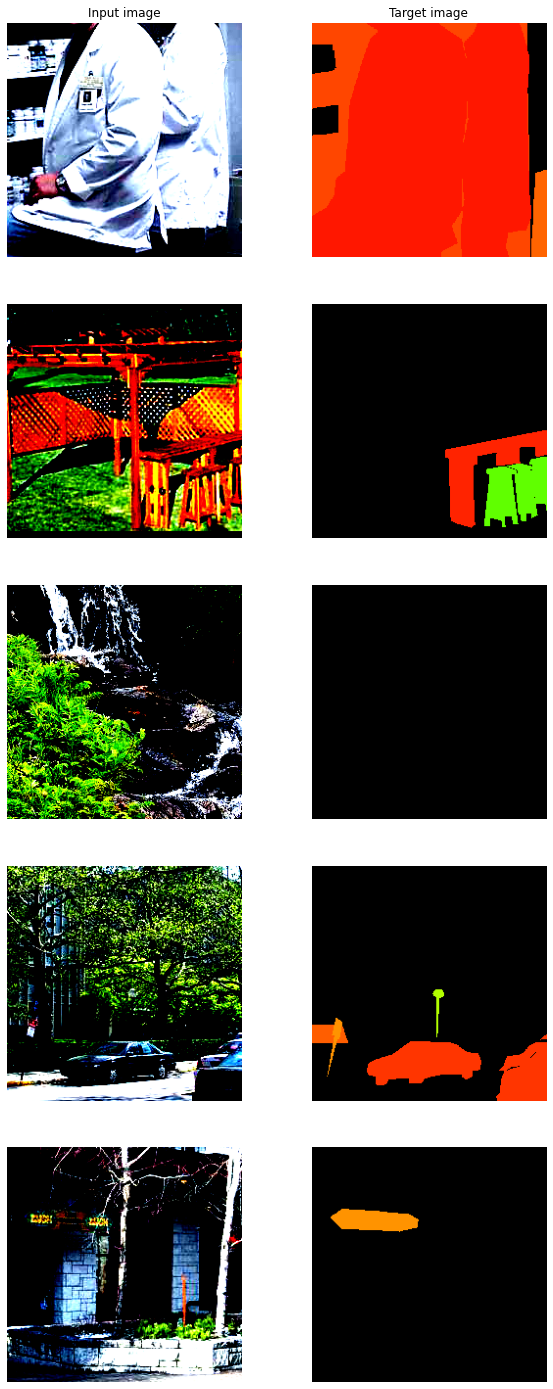

In [ ]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 5
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy(), cmap=cm.hsv, void_color="#000000FF"))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

In [ ]:
from IPython.display import clear_output
import io

class TrainingLogger(pl.callbacks.Callback):

    def __init__(self):
        self.train_epoch_path = []
        self.val_epoch_path   = []
        
    def on_train_epoch_start(self, trainer, module, *args, **kwargs):
        #print("Starts an epoch.", end="\r")
        self.train_epoch_path.append({'accumulate_loss': 0, 'accumulate_IoU': 0, 'path_len': 0, 'path': []})
    
    def on_train_batch_end(self, trainer, module, outputs, *args, **kwargs):
        loss, m_IoU = outputs['loss'], outputs['mean_IoU']
        last = self.train_epoch_path[-1]
        last['accumulate_loss'] += loss
        last['accumulate_IoU'] += m_IoU
        last['path_len'] += 1
        # last['path'].append(outputs)
        path_len = last['path_len']
        avg_loss = last['accumulate_loss'] / path_len
        avg_IoU  = last['accumulate_IoU'] / path_len
        #print("Training loss: %8.4f, mean_IoU: %8.4f, Avg loss: %8.4f, Avg IoU: %8.4f"%(loss, m_IoU, avg_loss, avg_IoU))
    
    def on_train_epoch_end(self, trainer, module, *args, **kwargs):
        optimizers = module.optimizers()
        lr = optimizers.optimizer.state_dict()['param_groups'][0]['lr']
        last = self.train_epoch_path[-1]
        path_len = last['path_len']
        avg_loss = last['accumulate_loss'] / path_len
        avg_IoU  = last['accumulate_IoU'] / path_len
        print("Training epoch avg loss: %8.4f, Avg IoU: %8.4f"%(avg_loss, avg_IoU))
        print("learning rate:", lr)

    def on_validation_epoch_start(self, trainer, module, *args, **kwargs):
        self.val_epoch_path.append({'accumulate_loss': 0, 'accumulate_IoU': 0, 'path_len': 0, 'path': []})
              
    def on_validation_batch_end(self, trainer, module, outputs, *args, **kwargs):
        loss, m_IoU = outputs['val_loss'], outputs['val_mean_IoU']
        last = self.val_epoch_path[-1]
        last['accumulate_loss'] += loss
        last['accumulate_IoU'] += m_IoU
        last['path_len'] += 1
        #last['path'].append(outputs)
        path_len = last['path_len']
        avg_loss = last['accumulate_loss'] / path_len
        avg_IoU  = last['accumulate_IoU'] / path_len
        #print("Val loss: %8.4f, mean_IoU: %8.4f, Avg loss: %8.4f, Avg IoU: %8.4f"%(loss, m_IoU, avg_loss, avg_IoU))

    def on_validation_epoch_end(self, trainer, module, *args, **kwargs):
        last = self.val_epoch_path[-1]
        path_len = last['path_len']
        avg_loss = last['accumulate_loss'] / path_len
        avg_IoU  = last['accumulate_IoU'] / path_len
        print("Validation epoch avg loss: %8.4f, Avg IoU: %8.4f"%(avg_loss, avg_IoU))

In [ ]:
hparams = {
    "batch_size": 24,
    "learning_rate": 0.0001,
    "L2": 1e-7,
}

model = SegmentationNN(num_classes=101, train_set=train_data, val_set=val_data, hparams=hparams)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='min'
)

logger = TrainingLogger()
 
trainer = pl.Trainer(
    max_epochs=30,
    gpus=1 if torch.cuda.is_available() else None,
    callbacks=[early_stop_callback, logger],
    log_every_n_steps=1
)

trainer.fit(model)

Sanity Checking: 0it [00:00, ?it/s]

Validation epoch avg loss:   4.7334, Avg IoU:   0.0002


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.7812, Avg IoU:   0.2665
Training epoch avg loss:   1.1337, Avg IoU:   0.2451
learning rate: 0.0001


Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.7201, Avg IoU:   0.2840
Training epoch avg loss:   0.7117, Avg IoU:   0.2876
learning rate: 0.0001


Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.6958, Avg IoU:   0.2866
Training epoch avg loss:   0.5844, Avg IoU:   0.3159
learning rate: 0.0001


Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.6929, Avg IoU:   0.2874
Training epoch avg loss:   0.4835, Avg IoU:   0.3407
learning rate: 0.0001


Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.7090, Avg IoU:   0.2968
Training epoch avg loss:   0.4119, Avg IoU:   0.3632
learning rate: 0.0001


Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.7100, Avg IoU:   0.2817
Training epoch avg loss:   0.3464, Avg IoU:   0.3895
learning rate: 0.0001


Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.7497, Avg IoU:   0.2827
Training epoch avg loss:   0.2985, Avg IoU:   0.4116
learning rate: 0.0001


Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.7206, Avg IoU:   0.3099
Training epoch avg loss:   0.2217, Avg IoU:   0.4803
learning rate: 4e-05


Validation: 0it [00:00, ?it/s]

Validation epoch avg loss:   0.7501, Avg IoU:   0.3099
Training epoch avg loss:   0.1801, Avg IoU:   0.5242
learning rate: 4e-05


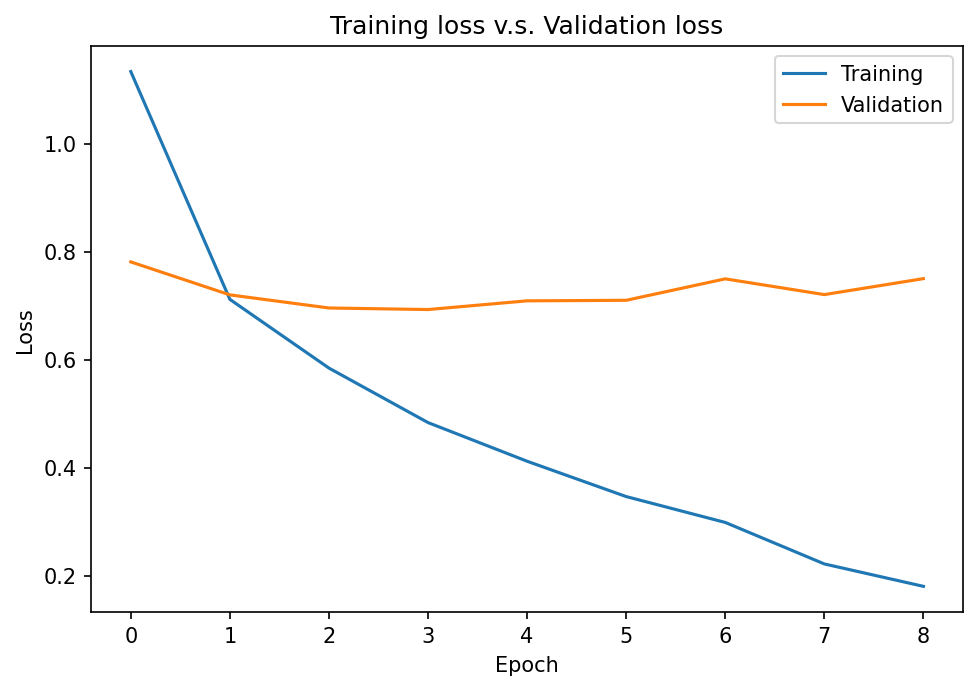

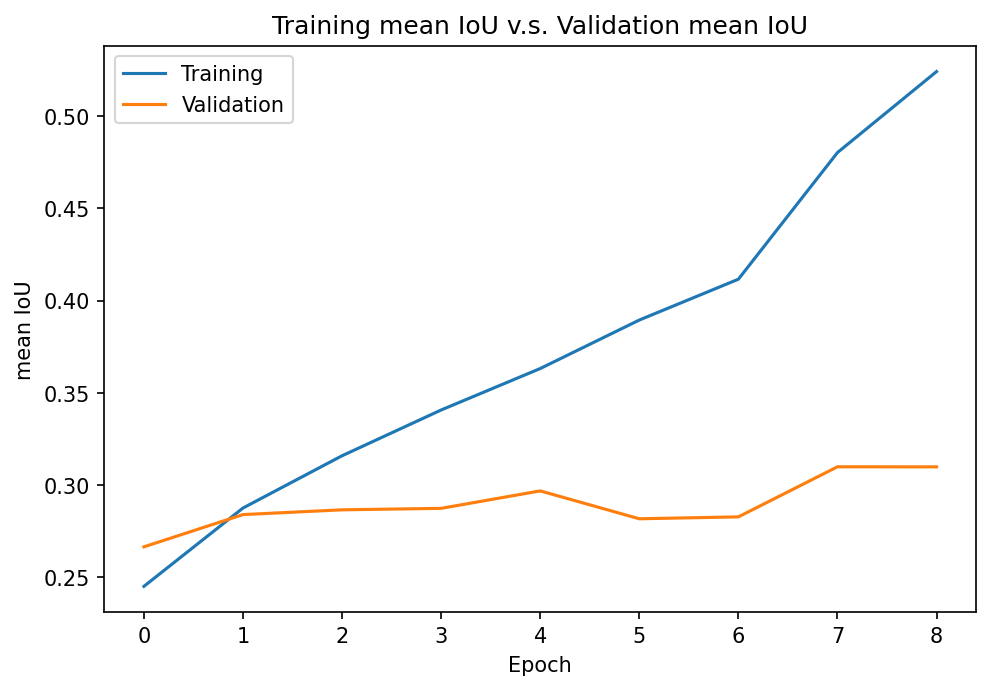

In [ ]:
training_loss = [*map(lambda x: x['accumulate_loss'].cpu().numpy() / x['path_len'], logger.train_epoch_path)]
training_miou = [*map(lambda x: x['accumulate_IoU'].cpu().numpy() / x['path_len'], logger.train_epoch_path)]
val_loss = [*map(lambda x: x['accumulate_loss'].cpu().numpy() / x['path_len'], logger.val_epoch_path[1:])]
val_miou = [*map(lambda x: x['accumulate_IoU'].cpu().numpy() / x['path_len'], logger.val_epoch_path[1:])]
loss_fig = plt.figure(figsize=(7.5, 5), dpi=150)
ax = loss_fig.add_subplot()
ax.plot(training_loss)
ax.plot(val_loss)
ax.set_title("Training loss v.s. Validation loss")
ax.legend(["Training", "Validation"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(range(len(logger.train_epoch_path)))
miou_fig = plt.figure(figsize=(7.5, 5), dpi=150)
ax = miou_fig.add_subplot()
ax.plot(training_miou)
ax.plot(val_miou)
ax.set_title("Training mean IoU v.s. Validation mean IoU")
ax.legend(["Training", "Validation"])
ax.set_xlabel("Epoch")
ax.set_ylabel("mean IoU")
ax.set_xticks(range(len(logger.train_epoch_path)))
pass

In [ ]:
model_root = "./models"
model_name = "model.pt"

if not os.path.isdir(model_root):
    os.mkdir(model_root)
torch.save(model.state_dict(), os.path.join(model_root, model_name))
torch.save(logger.train_epoch_path, os.path.join(model_root, "train_epoch_path"))
torch.save(logger.val_epoch_path, os.path.join(model_root, "val_epoch_path"))

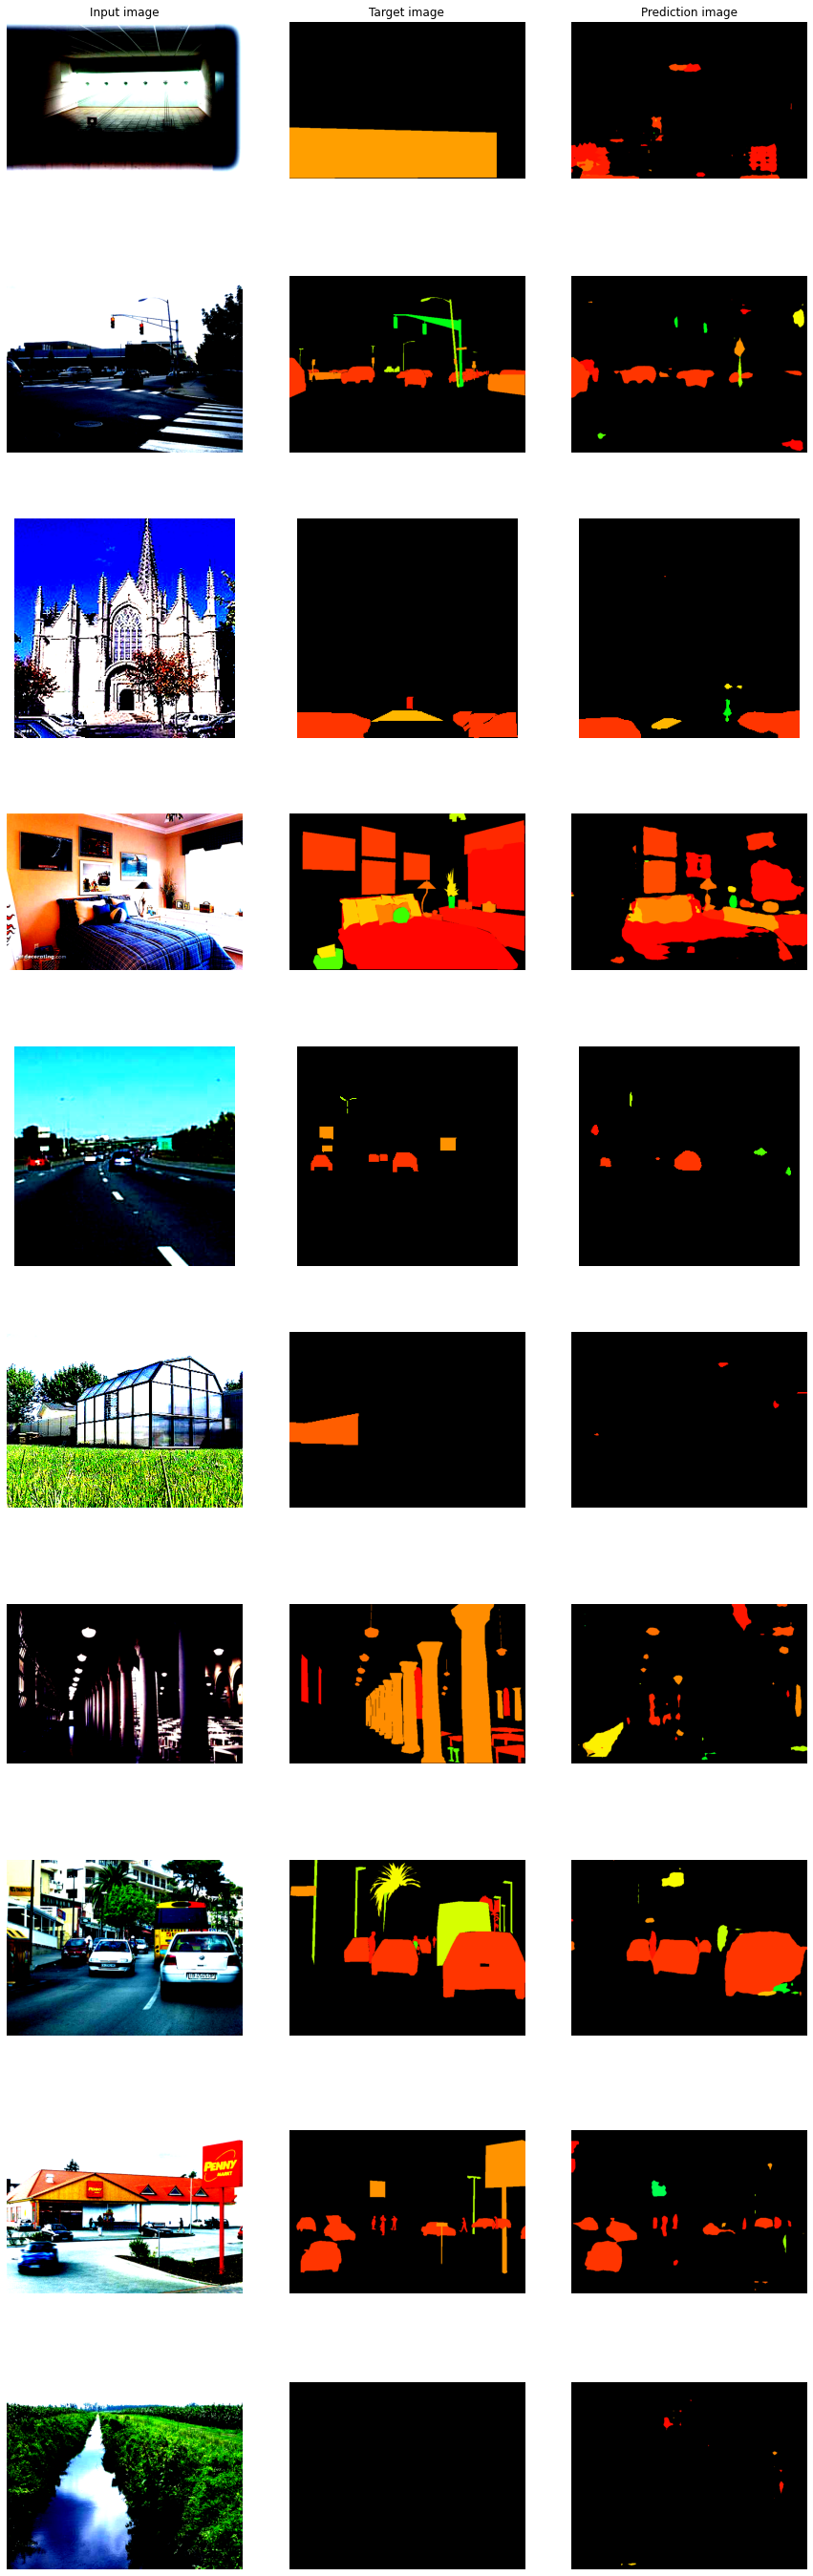

In [ ]:
config = dict(cmap=cm.hsv, void_color="#000000FF")
visualizer(model.to(device), original_val_data, num_example_imgs=10, rand=True, **config)

In [ ]:
#output = model(train_data[0][0][None])
#_, pred = torch.max(output, 1)
#plt.imshow(label_img_to_rgb(pred.detach().numpy(), cmap=cm.hsv, void_color="#000000FF"))